### A notebook to support academic question exploration and literature search / what do you do when you search the literature?

0. Define a research question e.g Is occupational **asbestos exposure** an underecognised **cause** of IPF? 
1. Consider the different possible ways of answering the question (methods). Different study designs and ways of measuring asbestos exposure e.g Epidemiological, observational, cross-sectional, cohort, case-control, post-mortem and explant studies, ecological, toxicology, animal models, molecular disease models, exposure assessment, occupational hygeinst measurements, minerologic analysis (tissue, BAL etc)
2. Generate search terms e.g "IPF", "case-control", "occupational", "asbestos" (? && mesh terms)
3. Carry out search using search terms and e.g pubmed, embase, google scholar, scopus, biorxiv, web of science, clinicaltrials.gov, ?google books
4. Search results == Candidate Papers
5. Extract title | journal | author | location | year | abstract | key words | full text && save result (as .bib) (prob want to export to jabref)
6. Review Candidate Papers to identify Relevant Papers 
7. Use Relevant Papers to identify more Candidate papers. Search also by author, cited by, cite, [triangle closing](https://en.wikipedia.org/wiki/Triadic_closure) e.g https://github.com/hinnefe2/bibcheck.py and other means (?tensorflow/scikit-learn,nltk)
8. Use the Relevant Papers collected for whatever it is they are relevant for (usually to help compose a written document in which they are cited)
9. ?django app times

meta: github/stack exchange etc to check out other peoples search strategies. this is likely to be formulated as a machine learning problem somewhere.

#### interesting related I found includes: https://www.projectcredo.com/, http://citationexplorer.hoppmann.me/, lict from a previous nhshackday, https://github.com/jvoytek/pubmedbrain/blob/f5170a2e3540e0c2aa665559c86048dfb1583f16/documents/Voytek-brainSCANrPreprint.pdf, https://github.com/graeham/hackathon/blob/master/paperGraph.py

### search github for relevant stuff with the following 'webbit' 
> https://github.com/search?l=Python&q=http%3A%2F%2Feutils.ncbi.nlm.nih.gov%2Fentrez%2Feutils%2Fesearch.fcgi++stars%3A%3E5&ref=advsearch&type=Code&utf8=%E2%9C%93

gists and interwebs inc stackoverflow also helpful

tempting to dive into django a la https://github.com/afouchet/OpenReview but probably not essential and now is not optimal timing

https://github.com/gui11aume looks well documented, poss useful template
https://github.com/swcarpentry/2013-08-23-harvard/blob/b2097bc20833e0a58b2e73eecd1227d61bd5a00a/lessons/misc-biopython/eutils.md looks like nice intro to biopython utils and https://gist.github.com/bonzanini/5a4c39e4c02502a8451d, https://gist.github.com/ehazlett/1104507, https://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 (for use of icite), https://gist.github.com/mcfrank/c1ec74df1427278cbe53, http://stackoverflow.com/questions/17409107/obtaining-data-from-pubmed-using-python, https://github.com/bwallace/abstrackr-web/tree/master/abstrackr, http://www.billconnelly.net/?p=44

### let's tackle pubmed first

In [1]:
"""
Notebook to support academic question exploration and literature search.

Thanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and 
http://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/ and vtrubets
https://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 

Pubmed advanced search is helpful for designing search/experimenting 
https://www.ncbi.nlm.nih.gov/pubmed/advanced

Docs for NCBI esearch:
https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch
https://www.nlm.nih.gov/bsd/mms/medlineelements.html
"""


'\nNotebook to support academic question exploration and literature search.\n\nThanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and \nhttp://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/ and vtrubets\nhttps://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 \n\nPubmed advanced search is helpful for designing search/experimenting \nhttps://www.ncbi.nlm.nih.gov/pubmed/advanced\n\nDocs for NCBI esearch:\nhttps://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch\nhttps://www.nlm.nih.gov/bsd/mms/medlineelements.html\n'

In [2]:
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm
import json
import requests
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_chunked_pmids(term, chunksize=50):
    """
    Return a list of Pubmed ids from pubmed search in chunks
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    count_handle = Entrez.esearch(db="pubmed",
                                  term=term,
                                  retmode="xml",
                                  rettype="count")
    count_results = Entrez.read(count_handle)
    count = int(count_results["Count"])

    retmax_requests = list(range(chunksize, count, chunksize))
    retmax_requests.append(count - retmax_requests[len(retmax_requests) - 1])

    for i, retmax in enumerate(retmax_requests):
        pmid_handle = Entrez.esearch(db="pubmed",
                                     term=term,
                                     sort="relevance",
                                     retmode="xml",
                                     usehistory='y',
                                     retstart=retmax,
                                     retmax=chunksize)
        results = Entrez.read(pmid_handle)
        yield results["IdList"]

In [4]:
def get_pubmed_summaries(pubmed_id):
    """
    Use the Pubmed API to return the summary of a pubmed article
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    pubmed_id = ', '.join(map(str, pubmed_id))
    handle = Entrez.esummary(db='pubmed', 
                             id=pubmed_id, 
                             retmode='json', 
                             rettype='abstract')
    return json.loads(handle.read())['result']
  

In [5]:
def get_pubmed_keywords(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the key words of a pubmed article.
    Return {pmid:[list of keywords]}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    keywords = {}
    for record in records:
        pmid = record.get('PMID','?')
        mh = record.get('MH','?')
        keywords[pmid] = mh
    return keywords

In [6]:
def get_pubmed_abstracts(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the abstract of a pubmed article.
    Return {pmid:abstract}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    abstracts = {}
    for record in records:
        pmid = record.get('PMID','?')
        ab = record.get('AB','?')
        abstracts[pmid] = ab
    return abstracts

In [7]:
def get_pubmed_pubtypes(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the abstract of a pubmed article.
    Return {pmid:pubtype}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    pubtypes = {}
    for record in records:
        pmid = record.get('PMID','?')
        pt = record.get('PT','?')
        pubtypes[pmid] = pt
    return pubtypes

In [8]:
def get_citation_information(pubmed_id):
    """
    Use the special citation api to return relative citation ratios
    """
    pubmed_id = ','.join(pubmed_id)
    citation_search = 'https://icite.od.nih.gov/api/pubs?pmids={0}'.format(pubmed_id)
    response = requests.get(citation_search).content
    str_response = response.decode('utf-8')
    
    try:
        data = json.loads(str_response)['data']
    except KeyError:
        data = False
         
    citations = {}
    
    if data:
        for record in data:
            pmid = record.get('pmid')
            rcr = record.get('relative_citation_ratio')
            citations[pmid] = rcr
            
    return citations
        

In [9]:
def lit_search(term):
    """
    Search pubmed for a term and collect information about the results
    """
    pmid_blocks = get_chunked_pmids(term, chunksize=200)
    summaries = []
    pubtypes = []
    abstracts = []
    keywords = []
    rcrs = []
    litsearch_results = [summaries, pubtypes, abstracts, keywords, rcrs]
    for i, block in enumerate(pmid_blocks):
        summaries.append(get_pubmed_summaries(block))
        pubtypes.append(get_pubmed_pubtypes(block))
        abstracts.append(get_pubmed_abstracts(block))
        keywords.append(get_pubmed_keywords(block))
        rcrs.append(get_citation_information(block))
        print("Processed block {0}".format(i))
    pickle.dump( litsearch_results, open( "litsearch_results_{0}.p".format(term), "wb" ) )
    return summaries, pubtypes, abstracts, keywords, rcrs
        

In [10]:
def lit_search_for_topic(topic):
    """
    Search pubmed for a term and collect information about the results
    """

    summaries = get_pubmed_summaries(topic)
    pubtypes = get_pubmed_pubtypes(topic)
    abstracts = get_pubmed_abstracts(topic)
    keywords = get_pubmed_keywords(topic)
    rcrs = get_citation_information(topic)
    #pickle.dump( litsearch_results, open( "litsearch_results_{0}.p".format(term), "wb" ) )
    
    return summaries, pubtypes, abstracts, keywords, rcrs
        

In [11]:
def make_result_dataframe( term, summaries, pubtypes, abstracts, keywords, rcrs ):
    
    pmid_blocks = get_chunked_pmids(term, chunksize=200)
    pmids = list(pmid_blocks)

    d = {}

    #for i, pmid in enumerate(pmids):
    for i, summary in enumerate(summaries):
        d[i] = pd.DataFrame(pmids[i], columns=['pmid'])
        d[i]['title'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['title'])
        d[i]['firstauthor'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['sortfirstauthor'])
        d[i]['lastauthor'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['lastauthor'])
        d[i]['journal'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['source'])
        d[i]['pubdate'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['sortpubdate'])
        d[i]['pubtype'] = d[i]['pmid'].map(lambda x: pubtypes[i].get(x))
        d[i]['abstract'] = d[i]['pmid'].map(lambda x: abstracts[i].get(x))
        d[i]['keywords'] = d[i]['pmid'].map(lambda x: keywords[i].get(x))
        d[i]['rcr'] = d[i]['pmid'].astype(int).map(lambda x: rcrs[i].get(x))
            
    df = pd.concat(d.values(), ignore_index=True)
    pd.set_option('max_colwidth',300)
    return df

In [12]:
def make_result_dataframe_for_topic( topic, summaries, pubtypes, abstracts, keywords, rcrs ):
    
    df = pd.DataFrame(topic, columns=['pmid'])
    df['title'] = df['pmid'].map(lambda x: summaries.get(x)['title'])
    df['firstauthor'] = df['pmid'].map(lambda x: summaries.get(x)['sortfirstauthor'])
    df['lastauthor'] = df['pmid'].map(lambda x: summaries.get(x)['lastauthor'])
    df['journal'] = df['pmid'].map(lambda x: summaries.get(x)['source'])
    df['pubdate'] = df['pmid'].map(lambda x: summaries.get(x)['sortpubdate'])
    df['pubtype'] = df['pmid'].map(lambda x: pubtypes.get(x))
    df['abstract'] = df['pmid'].map(lambda x: abstracts.get(x))
    df['keywords'] = df['pmid'].map(lambda x: keywords.get(x))
    df['rcr'] = df['pmid'].astype(int).map(lambda x: rcrs.get(x))
    pd.set_option('max_colwidth',300)
    return df

In [13]:
def save_results_as_csv(term, df):
    name = term.replace(" ", "-")
    df.to_csv(name+".csv")

In [14]:
def explore_result_dataframe(df):
    df.sort_values(by='rcr', ascending=False).head()
    df.firstauthor.value_counts().head()
    df.lastauthor.value_counts().head()
    df.journal.value_counts().head()
    df.pubtype.astype(str).value_counts().head()
    df[df.abstract.str.contains('case-control')].head()
    df.pubdate = pd.to_datetime(df.pubdate)
    df.index = df.pubdate
    df.groupby(df.pubdate.map(lambda x: x.year)).pmid.count().plot(kind='bar')

In [15]:
terms = ['idiopathic pulmonary fibrosis', 'cryptogenic fibrosing alveolitis',
        'usual interstitial pneumonia', 'asbestosis']

def litsearch_terms(terms):
    for term in terms:
        summaries, pubtypes, abstracts, keywords, rcrs = lit_search(term)
        df = make_result_dataframe( term, summaries, pubtypes, abstracts, keywords, rcrs )
        save_results_as_csv(term, df)
        print(explore_result_dataframe(df))

In [16]:
topic_collection = {"ipfjes_case_control_studies" : ['23022860', '10968375', '24413348', '19782552', '17628464', 
                                                     '10841131', '8569361', '8087336', '15640309', '9571528', 
                                                     '18507288', '23022860', '2249047'], 
                    "ipfjes_reviews" : ['25621562', '24348069', '10193340', '11816818', '15331187', '16733403']}


def litsearch_topics(topic_collection):
    for topic in topic_collection:
        summaries, pubtypes, abstracts, keywords, rcrs = lit_search_for_topic(topic_collection[topic])
        df = make_result_dataframe_for_topic( topic_collection[topic], summaries, pubtypes, abstracts, keywords, rcrs )
        save_results_as_csv(topic, df)
        

In [17]:
litsearch_topics(topic_collection)
    

In [18]:
df = pd.read_csv('ipfjes_case_control_studies.csv', usecols=['pmid','title','firstauthor','lastauthor',
                                                             'journal','pubdate','pubtype',
                                                             'abstract', 'keywords', 'rcr'])
pd.set_option('max_colwidth',300)

In [95]:
# clearly pubmed does not capture case-control studies as type observational
# mesh headings (keywords) look good though

df.pubdate = pd.to_datetime(df.pubdate)
df.index = df.pubdate.map(lambda x: x.year)
df = df.sort_values(by = 'pubdate', ascending=True)
df = df[['title','firstauthor', 'lastauthor', 'pubtype', 'keywords']]
df

,title,firstauthor,lastauthor,pubtype,keywords
pubdate,,,,,
1948,Idiopathic pulmonary fibrosis; roentgenologic findings.,ROBBINS LL,ROBBINS LL,['Journal Article'],"['*Activities of Daily Living', '*Advance Care Planning', '*Adverse Drug Reaction Reporting Systems', '*Agammaglobulinemia', '*Aging', '*Alpha-Globulins', '*Anti-Bacterial Agents', '*Apoptosis', '*Apoptosis/drug effects', '*Arthritis', '*Arthritis, Rheumatoid', '*Aspirin', '*Attitude to Health',..."
1950,Idiopathic pulmonary fibrosis; its occurrence in identical twin sisters.,PEABODY JW,HAYES EW Jr,['Journal Article'],"['*Activities of Daily Living', '*Advance Care Planning', '*Adverse Drug Reaction Reporting Systems', '*Agammaglobulinemia', '*Aging', '*Alpha-Globulins', '*Anti-Bacterial Agents', '*Apoptosis', '*Apoptosis/drug effects', '*Arthritis', '*Arthritis, Rheumatoid', '*Aspirin', '*Attitude to Health',..."
1953,[Chronic diffuse interstitial pulmonary fibrosis; idiopathic].,LEVINSKY L,LEVINSKY L,['Journal Article'],"['*Antioxidants', '*Apoptosis', '*Arthritis', '*Arthritis, Rheumatoid', '*Bile Ducts, Intrahepatic', '*Biopsy', '*Blood Protein Electrophoresis', '*Bronchoalveolar Lavage', '*Butylated Hydroxytoluene', '*Capillaries', '*Capsid Proteins', '*Carbon Dioxide', '*Cell Differentiation', '*Christianity..."
1955,[Idiopathic pulmonary fibrosis or atypical tuberculosis].,PANA C,PERELLI A,['Journal Article'],"['*Ambulatory Care', '*Apoptosis/drug effects', '*Arthroplasty, Replacement/adverse effects', '*Bibliometrics', '*Bleomycin', '*Bronchoalveolar Lavage', '*Cardiopulmonary Bypass', '*Cell Differentiation', '*Cold Temperature', '*Continuous Positive Airway Pressure', '*Data Interpretation, Statist..."
1956,HAMMAN RICH disease.,NaN,NaN,"['Case Reports', 'Journal Article']","['*Airway Resistance', '*Antigen-Antibody Complex', '*Antigens, CD44', '*Artificial Organs', '*Asbestos', '*Bacteria/genetics/growth & development/isolation & purification', '*Biopsy', '*Blood Vessel Prosthesis Implantation', '*Body Fluids', '*Bone Marrow Transplantation', '*Bronchoalveolar Lava..."
1957,[Idiopathic interstitial pulmonary fibrosis; anatomical and clinical contribution and indications for cortisone therapy].,PENNACCHIO L,PENNACCHIO L,"['Case Reports', 'Journal Article']","['*Adrenal Gland Neoplasms', '*Aging', '*Airway Remodeling', '*Algorithms', '*Antibody-Dependent Cell Cytotoxicity', '*Breast Neoplasms/complications/pathology', '*Bronchoalveolar Lavage Fluid/chemistry/cytology', '*CD8-Positive T-Lymphocytes', '*Carcinoma, Neuroendocrine/complications/pathology..."
1957,[Aspecific inflammation in the morphology &amp;amp; pathogenesis of Hamman-Rich idiopathic pulmonary fibrosis].,ANGELI F,DEL VIVO RE,['Journal Article'],"['*Activities of Daily Living', '*Advance Care Planning', '*Adverse Drug Reaction Reporting Systems', '*Agammaglobulinemia', '*Aging', '*Alpha-Globulins', '*Anti-Bacterial Agents', '*Apoptosis', '*Apoptosis/drug effects', '*Arthritis', '*Arthritis, Rheumatoid', '*Aspirin', '*Attitude to Health',..."
1959,[The relation of idiopathic organ scleroses to the collagen diseases demonstrated by pulmonary fibroses].,FALCK I,FALCK I,['Journal Article'],"['*Airway Resistance', '*Antigen-Antibody Complex', '*Antigens, CD44', '*Artificial Organs', '*Asbestos', '*Bacteria/genetics/growth & development/isolation & purification', '*Biopsy', '*Blood Vessel Prosthesis Implantation', '*Body Fluids', '*Bone Marrow Transplantation', '*Bronchoalveolar Lava..."
1959,[Considerations on the radiological aspects of idiopathic pulmonary fibrosis &amp;amp; of tuberculous fibrotic manifestations].,MARTINOTTI G,MOTTA R,['Journal Article'],"['*Ambulatory Care', '*Apoptosis/drug effects', '*Arthroplasty, Replacement/adverse effects', '*Bibliometrics', '*Bleomycin', '*Bronchoalveolar Lavage', '*Cardiopulmonary Bypass', '*Cell Differentiation', '*Cold Temperature', '*Continuous Positive Airway Pressure', '*Data Interpretation, Statist..."


In [94]:
df = pd.read_csv('idiopathic-pulmonary-fibrosis.csv', usecols=['pmid','title','firstauthor','lastauthor',
                                                             'journal','pubdate','pubtype',
                                                             'abstract', 'keywords', 'rcr'])

Number of pubmed IPF papers per year


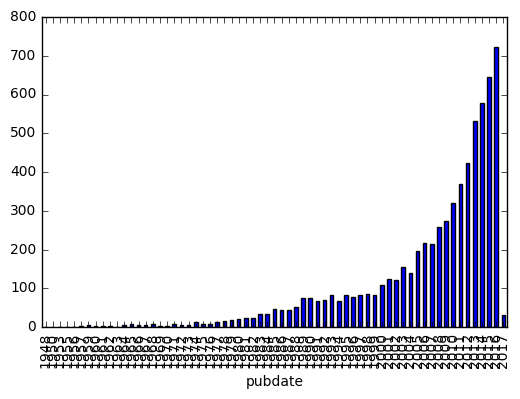

In [21]:
print ('Number of pubmed IPF papers per year')
explore_result_dataframe(df)

In [22]:
print ('Top 5 first authors for IPF')
df.firstauthor.value_counts().head()


Top 5 first authors for IPF


Raghu G        44
Cottin V       42
Selman M       27
Behr J         26
Antoniou KM    24
Name: firstauthor, dtype: int64

In [23]:
print ('Top 5 last authors for IPF')
df.lastauthor.value_counts().head()


Top 5 last authors for IPF


Collard HR    45
Wells AU      43
Bouros D      42
Raghu G       41
King TE Jr    39
Name: lastauthor, dtype: int64

In [24]:
print ('Top 5 journals for IPF')
df.journal.value_counts().head()


Top 5 journals for IPF


Am J Respir Crit Care Med    398
Chest                        273
Eur Respir J                 268
Respir Med                   158
Thorax                       144
Name: journal, dtype: int64

In [25]:
df.sort_values(by='rcr', ascending=False).head()


,pmid,title,firstauthor,lastauthor,journal,pubdate,pubtype,abstract,keywords,rcr
pubdate,,,,,,,,,,
2011-03-15,21471066,An official ATS/ERS/JRS/ALAT statement: idiopathic pulmonary fibrosis: evidence-based guidelines for diagnosis and management.,Raghu G,Schünemann HJ,Am J Respir Crit Care Med,2011-03-15,"['Journal Article', 'Practice Guideline', ""Research Support, Non-U.S. Gov't""]","This document is an international evidence-based guideline on the diagnosis and management of idiopathic pulmonary fibrosis, and is a collaborative effort of the American Thoracic Society, the European Respiratory Society, the Japanese Respiratory Society, and the Latin American Thoracic Associa...","['*Activities of Daily Living', '*Airway Remodeling', '*Anti-Inflammatory Agents, Non-Steroidal/administration & dosage/adverse effects', '*Bronchoalveolar Lavage Fluid', '*Cell Cycle', '*Cell Differentiation/drug effects/genetics', '*Cell Movement', '*Decision Support Techniques', '*Diagnostic ...",102.409113
2014-05-29,24836310,Efficacy and safety of nintedanib in idiopathic pulmonary fibrosis.,Richeldi L,Collard HR,N Engl J Med,2014-05-29,"['Clinical Trial, Phase III', 'Journal Article', 'Multicenter Study', 'Randomized Controlled Trial', ""Research Support, Non-U.S. Gov't""]",BACKGROUND: Nintedanib (formerly known as BIBF 1120) is an intracellular inhibitor that targets multiple tyrosine kinases. A phase 2 trial suggested that treatment with 150 mg of nintedanib twice daily reduced lung-function decline and acute exacerbations in patients with idiopathic pulmonary fi...,"['*Activities of Daily Living', '*Aging', '*Apoptosis', '*Attitude to Health', '*Autophagy', '*Biomarkers', '*Capnography', '*Cell Aging', '*Cell Transformation, Neoplastic', '*Communication', '*Comorbidity', '*Consensus', '*DNA Methylation', '*Disease Management', '*Disease Progression', '*Drug...",62.965059
2008-01-01,18161745,Cellular and molecular mechanisms of fibrosis.,Wynn TA,Wynn TA,J Pathol,2008-01-01,"['Journal Article', 'Research Support, N.I.H., Intramural', 'Review']","Fibrosis is defined by the overgrowth, hardening, and/or scarring of various tissues and is attributed to excess deposition of extracellular matrix components including collagen. Fibrosis is the end result of chronic inflammatory reactions induced by a variety of stimuli including persistent inf...","['*Adenovirus Infections, Human', '*Antibiotics, Antineoplastic', '*Apoptosis', '*Asian Continental Ancestry Group', '*Bleomycin', '*Bronchoscopy', '*Cell Hypoxia', '*Cell Movement', '*Cell Proliferation', '*Coronary Artery Bypass', '*DNA Methylation/drug effects', '*Dental Technicians', '*Disea...",53.192960
2013-09-15,24032382,An official American Thoracic Society/European Respiratory Society statement: Update of the international multidisciplinary classification of the idiopathic interstitial pneumonias.,Travis WD,Valeyre D,Am J Respir Crit Care Med,2013-09-15,"['Journal Article', 'Practice Guideline', ""Research Support, Non-U.S. Gov't""]","BACKGROUND: In 2002 the American Thoracic Society/European Respiratory Society (ATS/ERS) classification of idiopathic interstitial pneumonias (IIPs) defined seven specific entities, and provided standardized terminology and diagnostic criteria. In addition, the historical ""gold standard"" of hist...","['*Apoptosis', '*Attitude to Health', '*Autophagy/drug effects', '*Breath Tests', '*Bronchiectasis/drug therapy', '*Bronchoalveolar Lavage', '*Clinical Trials as Topic', '*Congresses as Topic', '*Cordyceps', '*DNA Damage', '*Drug Discovery', '*Dust/analysis', '*Epithelial-Mesenchymal Transition'...",51.915389
2015-07-15,26177183,An Official ATS/ERS/JRS/ALAT Clinical Practice Guideline: Treatment of Idiopathic Pulmonary Fibrosis. An Update of the 2011 Clinical Practice Guideline.,Raghu G,Schünemann HJ,Am J Respir Crit Care Med,2015-07-15,"['Journal Article', 'Practice Guideline']","BACKGROUND: This document updates the American Thoracic Society/European Respiratory Soc

In [103]:
keywords = get_pubmed_keywords(topic_collection['ipfjes_case_control_studies'])

print ('Top pubmed keywords (mesh headings)',
       'for the {0} occupational IPF case-control studies found'.format(len(keywords)))

corpus = []
       
for record in keywords:
    corpus.append(keywords[record])
    
corpus = [item for sublist in corpus for item in sublist]

x = Counter(corpus)

[(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)]

Top pubmed keywords (mesh headings) for the 12 occupational IPF case-control studies found


[('Male', 12),
 ('Humans', 12),
 ('Female', 12),
 ('Case-Control Studies', 10),
 ('Aged', 8),
 ('Middle Aged', 7),
 ('Risk Factors', 6),
 ('Adult', 5),
 ('Pulmonary Fibrosis/*etiology', 4),
 ('Wood', 3),
 ('Surveys and Questionnaires', 3),
 ('Odds Ratio', 3),
 ('Metals', 3),
 ('Dust', 3),
 ('*Occupational Exposure', 3),
 ('Smoking/adverse effects', 2),
 ('Smoking/*adverse effects', 2),
 ('Sex Factors', 2),
 ('Pulmonary Fibrosis/*mortality', 2),
 ('Occupational Exposure/*adverse effects/statistics & numerical data', 2),
 ('Occupational Exposure', 2),
 ('Dust/*adverse effects', 2),
 ('Aged, 80 and over', 2),
 ('Adolescent', 2),
 ('*Environmental Exposure', 2),
 ('Wood/*adverse effects', 1),
 ('United States/epidemiology', 1),
 ('United Kingdom/epidemiology', 1),
 ('Time Factors', 1),
 ('Sweden/epidemiology', 1),
 ('Sex Distribution', 1),
 ('Severity of Illness Index', 1),
 ('Risk Assessment', 1),
 ('Risk', 1),
 ('Retrospective Studies', 1),
 ('Regression Analysis', 1),
 ('Pulmonary Fibro